In [1]:
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [2]:
NUMBER_OF_PICTURES = 1818

In [3]:
import os
from tqdm import tqdm 
def img_to_array(img):
    return np.asarray(img)
SIZE=200
clean_data=[]
path = 'dataset2.0'
files=os.listdir(path)
for i in tqdm(files):
    img=cv2.imread(path+'/'+i)  #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clean_data.append(img_to_array(img))


100%|██████████| 1818/1818 [06:25<00:00,  4.71it/s]


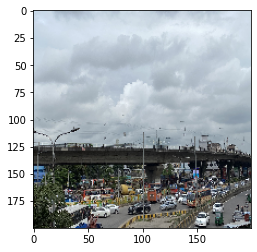

In [4]:
clean_data=clean_data[:NUMBER_OF_PICTURES]
plt.imshow(clean_data[0],cmap='binary')
new_clean=[]
for i in clean_data:
    i=i/255
    new_clean.append(i)

In [5]:
for i in new_clean:
    x=i
    x[x<0.5]=0

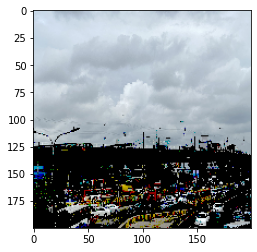

In [6]:
plt.imshow(new_clean[0],cmap='binary')

In [7]:
len(new_clean)

1818

In [8]:
arr_ind =  np.arange(NUMBER_OF_PICTURES)
mean_row=[]
for i in arr_ind:
    mean_row.append(np.mean(new_clean[i][120]))
mean_array=np.array(mean_row)

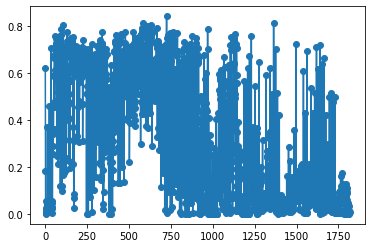

In [9]:
plt.scatter(arr_ind,mean_array)
plt.plot(arr_ind,mean_array)
plt.show()

In [10]:
for i in range(len(new_clean)):
    new_clean[i]=new_clean[i][:120]

In [11]:
df=pd.read_excel('dataset_2.0.xlsx', engine='openpyxl').head(NUMBER_OF_PICTURES)

In [12]:
y=df['PM2.5']
y=np.array(y)
print(type(y))

<class 'numpy.ndarray'>


In [13]:
new_clean[0].shape

(120, 200, 3)

In [14]:
X=new_clean
X=np.array(X)

print(type(X))


<class 'numpy.ndarray'>


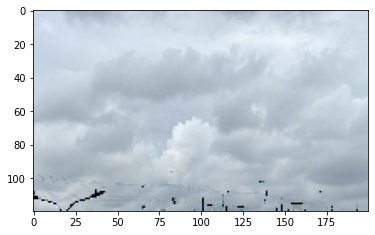

In [15]:

plt.imshow(new_clean[0],cmap='binary')

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.10, random_state = 42,shuffle=True)

In [17]:
x_train = x_train.reshape(-1,120,200, 3)

x_test = x_test.reshape(-1,120,200, 3)

In [18]:

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1636, 120, 200, 3)
(182, 120, 200, 3)
(1636,)
(182,)


In [19]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, Add
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
optimum=Adam(learning_rate=0.000001)

# K-FOLD

In [20]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

# Merge inputs and targets
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

for train, test in kfold.split(inputs, targets):

    model = tf.keras.models.Sequential([
    tf.keras.layers.ZeroPadding2D(padding=(3, 3), input_shape=(120,200,3)),
    # First Conv2d Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Second Conv2d Block
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2), 
    # Third Conv2d Block
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Fourth Conv2d Block
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Fifth and Final Conv2d Block
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Fully Connected Layer
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1,activation='linear')  
    ])

  # Compile the model
    model.compile(optimizer=optimum, loss='mean_absolute_error',metrics=['mean_squared_error',tf.keras.metrics.RootMeanSquaredError()])


  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=8,
              epochs=350,
              verbose=1)

  # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]}')
    #acc_per_fold.append(scores[1] * 100)
    #loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/350
205/205 [==============================] - 24s 33ms/step - loss: 140.8597 - mean_squared_error: 23333.2363 - root_mean_squared_error: 152.7522
Epoch 2/350
205/205 [==============================] - 6s 29ms/step - loss: 123.6890 - mean_squared_error: 19398.6719 - root_mean_squared_error: 139.2791
Epoch 3/350
205/205 [==============================] - 6s 30ms/step - loss: 103.7234 - mean_squared_error: 15343.1074 - root_mean_squared_error: 123.8673 1s - loss: 107.0748 - mean_s
Epoch 4/350
205/205 [==============================] - 6s 30ms/step - loss: 87.8771 - mean_squared_error: 11700.0381 - root_mean_squared_error: 108.1667
Epoch 5/350
205/205 [==============================] - 6s 28ms/step - loss: 75.6297 - mean_squared_error: 8840.2559 - root_mean_squared_error: 94.0226: 2s - loss: 77.6596 - mean_squared_erro
Epoch 6/350
205/205 [==============================] - 6s 28ms/step

Score for fold 1: loss of 30.022417068481445; mean_squared_error of 1820.6689453125; root_mean_squared_error of 42.66929626464844

Score for fold 2: loss of 30.870418548583984; mean_squared_error of 1892.781982421875; root_mean_squared_error of 43.5061149597168

Score for fold 3: loss of 31.987964630126953; mean_squared_error of 1896.530517578125; root_mean_squared_error of 43.549171447753906

Score for fold 4: loss of 31.5903263092041; mean_squared_error of 2066.20166015625; root_mean_squared_error of 45.45549011230469

Score for fold 5: loss of 33.577545166015625; mean_squared_error of 2180.861328125; root_mean_squared_error of 46.69969177246094

Score for fold 6: loss of 30.751291275024414; mean_squared_error of 1928.7518310546875; root_mean_squared_error of 43.91755676269531

Score for fold 7: loss of 33.89514923095703; mean_squared_error of 2370.8271484375; root_mean_squared_error of 48.691139221191406

Score for fold 8: loss of 33.14117431640625; mean_squared_error of 2279.02294921875; root_mean_squared_error of 47.739112854003906

Score for fold 9: loss of 32.22853088378906; mean_squared_error of 2263.60107421875; root_mean_squared_error of 47.57731628417969

Score for fold 10: loss of 30.063705444335938; mean_squared_error of 2064.82275390625; root_mean_squared_error of 45.4403190612793